In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from lml import LML

from copy import deepcopy

from model.layers import KHopfield

from model.lml2 import LML2

from matplotlib import pyplot as plt
# set auto reload
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import numpy as np

import pandas as pd

from datasets import load_dataset

ti_dataset = load_dataset("zh-plus/tiny-imagenet", split='valid')

Using custom data configuration Maysee--tiny-imagenet-fd536421864cbb86
Reusing dataset parquet (/data/home/sjaffe/.cache/huggingface/datasets/zh-plus___parquet/Maysee--tiny-imagenet-fd536421864cbb86/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [140]:
# load mnist, take the build a matrix of all pairwiase distances
# load mnist
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST('~/data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('~/data', train=False, download=True, transform=transform)

# load data
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


In [141]:
# load cifar10 test data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
cifar10_test_data = datasets.CIFAR10('~/data', train=False, download=True, transform=transform)
cifar10_test_loader = DataLoader(cifar10_test_data, batch_size=1, shuffle=False)


Files already downloaded and verified


In [138]:
# max of ciar10
cifar10_max = cifar10_test_data.data.max()
cifar10_max

255

In [136]:
cifar10_min

array([0, 0, 0], dtype=uint8)

In [131]:
# returns a matrix of pairwaise distances
def pair_wise_distance(dataset, norm = 2):
    # get the number of samples
    n = len(dataset)
    # get the dimension of the data
    # create a matrix to store the distances
    distances = torch.zeros((n, n))
    
    # create a batch loader

    batch_size = 1000
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # iterate over the batches
    
    inner_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for i, (x, _) in tqdm(enumerate(loader), total=len(loader)):
        # compute the distances
        for j, (x2, _) in enumerate(inner_loader):
            # compute the distancetorch.cdist(x, x2, p=norm)
            dists = torch.cdist(x.flatten(start_dim=1), x2.flatten(start_dim=1), p=norm)
            distances[i*batch_size:(i+1)*batch_size, j*batch_size:(j+1)*batch_size] = dists
    return distances

In [165]:
# # compute the pairwise distances of test data
distances = pair_wise_distance(cifar10_test_data, norm = 2)

# # # save in data folder
torch.save(distances, 'data/cifar10_test_distances_l1.pt')
distances = torch.load('data/cifar10_test_distances_l1.pt')

Using custom data configuration Maysee--tiny-imagenet-fd536421864cbb86
Reusing dataset parquet (/data/home/sjaffe/.cache/huggingface/datasets/zh-plus___parquet/Maysee--tiny-imagenet-fd536421864cbb86/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [170]:
ti_ds = ti_dataset.with_format("torch")

In [183]:
img = ti_dataset[0]['image']

# convert JpegImageFile to tensor
img = transforms.ToTensor()(img).flatten()
img.shape

torch.Size([12288])

In [235]:
class TinyImagenetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        dataset =  load_dataset("zh-plus/tiny-imagenet", split='valid')
        self.imgs = []
        self.labels = []
        for i, d in enumerate(dataset):
            
            img = transforms.ToTensor()(d['image']).flatten()
            if img.shape[0] == 3*64*64:
                self.imgs.append(img)
                self.labels.append(d['label'])

        self.n = len(self.imgs)
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]
    
    def __repr__(self):
        return f"TinyImagenetDataset(n={self.n})"
    
# make a wrapper aroudn mnist dataset
class DatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __getitem__(self, index):
        return self.dataset[index][0].flatten(), self.dataset[index][1], index
    def __len__(self):
        return len(self.dataset)
    
# create a dataset wrapper
test_dataset_w = DatasetWrapper(test_data)
test_loader_w = DataLoader(test_dataset_w, batch_size=1, shuffle=False)

In [236]:
ti_dataset = load_dataset("zh-plus/tiny-imagenet", split='valid')
ti_ds = TinyImagenetDataset(ti_dataset)
ti_ds_w = DatasetWrapper(ti_ds)

Using custom data configuration Maysee--tiny-imagenet-fd536421864cbb86
Reusing dataset parquet (/data/home/sjaffe/.cache/huggingface/datasets/zh-plus___parquet/Maysee--tiny-imagenet-fd536421864cbb86/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration Maysee--tiny-imagenet-fd536421864cbb86
Reusing dataset parquet (/data/home/sjaffe/.cache/huggingface/datasets/zh-plus___parquet/Maysee--tiny-imagenet-fd536421864cbb86/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [237]:
ti_ds.imgs[0].shape
ti_ds[0]

(tensor([0.9608, 0.9725, 0.9765,  ..., 1.0000, 1.0000, 1.0000]), 0)

In [239]:
for img, l in ti_ds:
    if img.shape[0] != 3*64*64:
        print(img.shape)

In [240]:
distances = pair_wise_distance(ti_ds, norm = 1)

# # # save in data folder
torch.save(distances, 'data/tinyimagenet_test_distances_l1.pt')
distances = torch.load('data/tinyimagenet_test_distances_l1.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

In [242]:
distances[0]

tensor([   0.0000, 4512.1357, 3121.8987,  ..., 3717.7961, 3050.6807,
        3888.5110])

In [247]:
distances = torch.load('data/cifar10_test_distances_l1.pt')
distances[0]

tensor([   0.0000, 5465.3311, 4053.3059,  ..., 4516.2466, 3398.4976,
        3268.8760])

In [248]:
distances = torch.load('data/mnist_test_distances_l1.pt')
distances[0]

tensor([  0.0000, 498.8451, 301.4682,  ..., 331.5323, 379.2887, 597.4507])

In [274]:

def get_k_retrieval_exp(dataset, memories = 1000, p=1, seed=0, batch_size = 1):
    if dataset== 'cifar10':
        distances = torch.load('data/cifar10_test_distances_l1.pt')
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
        test_data = datasets.CIFAR10('~/data', train=False, download=True, transform=transform)
        d = 3*32*32
    elif dataset == 'mnist':
        distances = torch.load('data/mnist_test_distances_l1.pt')

        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        test_data = datasets.MNIST('~/data', train=False, download=True, transform=transform)

        d = 28*28
    elif dataset == 'tinyimagenet':
        distances = torch.load('data/tinyimagenet_test_distances_l1.pt')
        ti_dataset = load_dataset("zh-plus/tiny-imagenet", split='valid')
        test_data = TinyImagenetDataset(ti_dataset)
        d = 3*64*64
    # get random subset of indices
    # set seed
    np.random.seed(seed)
    indices = np.random.choice(len(test_data), memories, replace=False)
    
    dataset_subset = Subset(test_data, indices=indices)
    dataset_subset_w = DatasetWrapper(dataset_subset)
    
    test_loader_w = DataLoader(dataset_subset_w, batch_size=batch_size, shuffle=False)

    # get only the rows of the distances matrix where the row and column indices are in indices list
    distances_subset = distances[indices][:, indices]

    # assert diagonal elements of distances_subset are zero
    
    hopfield = KHopfield(memories, d, p=p)
    hopfield.set_memories_from_loader(test_loader_w)
    return distances_subset, hopfield, test_loader_w

    

In [251]:
# make a hopfield network
distances, hopfield, test_loader_w = get_k_retrieval_exp('tinyimagenet', memories = 1000, p=1)

Using custom data configuration Maysee--tiny-imagenet-fd536421864cbb86
Reusing dataset parquet (/data/home/sjaffe/.cache/huggingface/datasets/zh-plus___parquet/Maysee--tiny-imagenet-fd536421864cbb86/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration Maysee--tiny-imagenet-fd536421864cbb86
Reusing dataset parquet (/data/home/sjaffe/.cache/huggingface/datasets/zh-plus___parquet/Maysee--tiny-imagenet-fd536421864cbb86/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


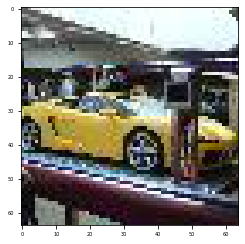

In [255]:
# print first image in test_loader_w
# show first image which is 3x64x64
plt.imshow(test_loader_w.dataset[0][0].reshape(3, 64, 64).permute(1, 2, 0))

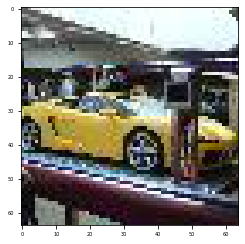

In [257]:
# print first image in memory
plt.imshow(hopfield.memories[0].reshape(3, 64, 64).permute(1, 2, 0).detach().numpy(), cmap='gray')

In [12]:
hopfield.memories.shape

torch.Size([1000, 784])

In [258]:

def get_k_precission(true_top_k, predicted_top_k):
    # true top_k is a torch tensor batch_size x k
    # predicted top_k is a torch tensor batch_size x k
    # compute the recall which is a b vector
    k = predicted_top_k.shape[1]
    b = predicted_top_k.shape[0]
    # compute the recall
    precision = torch.zeros(b)
    for i in range(b):
        intersection = np.intersect1d(true_top_k[i].numpy(), predicted_top_k[i].numpy())
        precision[i] = len(intersection)/k
    return precision

In [259]:

def get_k_recall(true_top_k, predicted_top_k):
    # true top_k is a torch tensor batch_size x k
    # predicted top_k is a torch tensor batch_size x k
    # compute the recall which is a b vector
    k = true_top_k.shape[1]
    b = true_top_k.shape[0]
    # compute the recall
    recall = torch.zeros(b)
    for i in range(b):
        intersection = np.intersect1d(true_top_k[i].numpy(), predicted_top_k[i].numpy())
        recall[i] = len(intersection)/k
    return recall

In [262]:
def k_recall_exp(test_loader_w, distances, k, seed=0, var=0, beta=1):
    total_seen = 0
    total_k_recall = torch.zeros(k)
    total_k_precision = torch.zeros(k)
    for batch_idx, batch in tqdm(enumerate(test_loader_w), total = len(test_loader_w)):
        x, y, i = batch
        total_seen += len(x)
        # get rows of distance matrix from every element in batch

        # add noise to x
        torch.manual_seed(seed)
        x = x + (torch.randn_like(x) * var)
        # clamp x
        # x = torch.clamp(x, -0.4242, 2.8215)

        dists = distances[i]
        
        # get the top k
        top_k = torch.argsort(dists, dim=1)[:, :k]

        # k hopfield
        scores = hopfield(x,  k=k, beta = beta, hopfield_steps=0, index=True)
        reported_argmax = torch.argmax(scores, dim=1)

        # uses simple softmax and argsort
        # scores = hopfield.soft_index(hopfield.memories, x,  beta = beta)
        # reported_argmax = torch.argsort(scores, descending=True, dim=1)[:, :k]


        for j in range(1, k+1):
            # from https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
            # recall@k is the fraction of the k most similar items in the database that are also present in the k most similar items in the result of the query.
            # # which looks like precision to me but whatever
            # k_precision = get_k_precission(top_k, reported_argmax[:,:j])
            # total_k_precision[j-1] += torch.sum(k_precision)

            k_recall = get_k_recall(top_k[:,:j], reported_argmax[:,:j])
            total_k_recall[j-1] += torch.sum(k_recall)
        
    return total_k_recall / total_seen, total_k_precision / total_seen

In [3]:
distances, hopfield, test_loader_w = get_k_retrieval_exp(dataset='tinyimagenet', memories = 1000, p=1,  batch_size =100)

NameError: name 'get_k_retrieval_exp' is not defined

In [271]:
recall, precission = k_recall_exp(test_loader_w, distances, k=50, seed=0, var=1, beta=1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [269]:
# make precision recall plot   
# prepend 0 to recall and precision
recall

tensor([1.0000, 0.7195, 0.6843, 0.6752, 0.6736, 0.6720, 0.6760, 0.6812, 0.6828,
        0.6801, 0.6812, 0.6867, 0.6877, 0.6894, 0.6905, 0.6934, 0.6965, 0.6963,
        0.6971, 0.6990, 0.7007, 0.7020, 0.7045, 0.7053, 0.7065, 0.7060, 0.7053,
        0.7054, 0.7057, 0.7070, 0.7078, 0.7089, 0.7098, 0.7101, 0.7107, 0.7113,
        0.7112, 0.7120, 0.7120, 0.7123, 0.7130, 0.7139, 0.7147, 0.7147, 0.7150,
        0.7147, 0.7141, 0.7141, 0.7155, 0.7158])

In [89]:
len(recall)

2

In [289]:
# get dists[j,k] where j in i and k in 
variances = [0, .25, .5, .75, 1, 1.25, 1.5]

# make a pandas dataframe to store the results
mean_pd = pd.DataFrame(columns=['variance', 'k', 'recall'])
std_pd = pd.DataFrame(columns=['variance', 'k', 'recall'])

K=50
n_trials = 1
for var in variances:
    print(f"Var: {var}")
    trials = []
    for i in range(n_trials):
        recall, precission = k_recall_exp(test_loader_w, distances, k=50, seed=i, var=var, beta=1)
        trials.append(recall)
    mean = torch.mean(torch.stack(trials), dim=0).detach().numpy()
    std = torch.std(torch.stack(trials), dim=0).detach().numpy()

    for k in range(1, K+1):
        mean_pd = mean_pd.append({'variance': var, 'k': k, 'recall': mean[k-1]}, ignore_index=True)
        std_pd = std_pd.append({'variance': var, 'k': k, 'recall': std[k-1]}, ignore_index=True)


Var: 0


  0%|          | 0/10 [00:00<?, ?it/s]

Var: 0.25


  0%|          | 0/10 [00:00<?, ?it/s]

Var: 0.5


  0%|          | 0/10 [00:00<?, ?it/s]

Var: 0.75


  0%|          | 0/10 [00:00<?, ?it/s]

Var: 1


  0%|          | 0/10 [00:00<?, ?it/s]

Var: 1.25


  0%|          | 0/10 [00:00<?, ?it/s]

Var: 1.5


  0%|          | 0/10 [00:00<?, ?it/s]

In [291]:
# save pd frames
# mean_pd.to_csv('data/mnist_mean_pd_.csv')
# std_pd.to_csv('data/mnist_std_pd.csv')
# print("saved mnist")

# mean_pd.to_csv('data/cifar10_mean_pd_.csv')
# std_pd.to_csv('data/cifar10_std_pd.csv')
# print("saved cifar10")

mean_pd.to_csv('data/tinyimagenet_mean_pd_.csv')
std_pd.to_csv('data/tinyimagenet_std_pd.csv')
print("saved tinyimagenet")

saved tinyimagenet


In [12]:
# make a plot of the results 
def make_plot(mean_pd, std_pd, variances, title, meta_info=False):
    
    fig, ax = plt.subplots(figsize=(6, 6))
    for var in variances:
        plt.plot(mean_pd[mean_pd['variance'] == var]['k'], mean_pd[mean_pd['variance'] == var]['recall'], label='$\sigma^2$: {}'.format(var), linewidth=2)
        #plt.fill_between(mean_pd[mean_pd['variance'] == var]['k'], mean_pd[mean_pd['variance'] == var]['recall'] - std_pd[std_pd['variance'] == var]['recall'], mean_pd[mean_pd['variance'] == var]['recall'] + std_pd[std_pd['variance'] == var]['recall'], alpha=.1)
    # put legend in lower right corner
    plt.xlabel('k')

    #make y axis from 0 to 1
    plt.ylim(.5, 1)
    plt.xlim(1, 50)
    #font size
    plt.rcParams.update({'font.size': 15})

    #title
    plt.title(title)
    # turn off y tiks
    

    if meta_info:
        plt.ylabel('k-recall@k')
        # turn y axis labels on

        ax.set_yticklabels([.5, .6, .7, .8, .9, 1])
        plt.legend(loc='lower left')

    else:
        ax.set_yticklabels([])
    # add a grid
    plt.grid(which='major', axis='both')
    # make grid have horizontal lines, even if no y ticks
    plt.gca().yaxis.grid(True, which='minor')



/data/home/sjaffe/graph3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


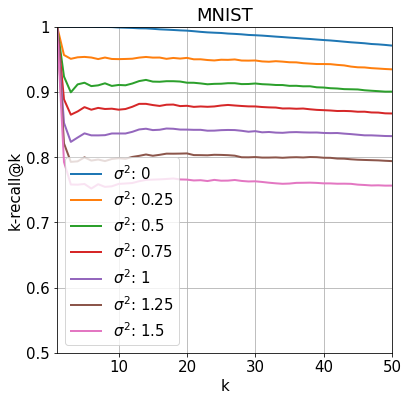

In [14]:
# save pd frames
# load mnist pds
mean_pd = pd.read_csv('data/mnist_mean_pd_.csv')
std_pd = pd.read_csv('data/mnist_std_pd.csv')

variances = [0, .25, .5, .75, 1, 1.25, 1.5]
make_plot(mean_pd, std_pd, variances, title = 'MNIST', meta_info=True)
# save as jpg
plt.savefig('figures/mnist_k_recall.jpg', dpi=300)

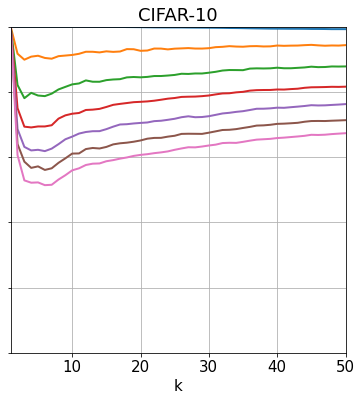

In [17]:
# load cifar10 pds
mean_pd = pd.read_csv('data/cifar10_mean_pd_.csv')
std_pd = pd.read_csv('data/cifar10_std_pd.csv')
make_plot(mean_pd, std_pd, variances, title='CIFAR-10', meta_info=False)
plt.savefig('figures/cifar10_k_recall.jpg', dpi=300)

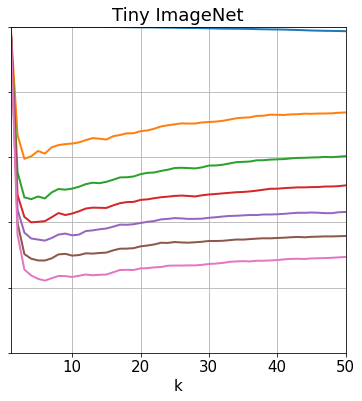

In [18]:
# load tinyimagenet pds
mean_pd = pd.read_csv('data/tinyimagenet_mean_pd_.csv')
std_pd = pd.read_csv('data/tinyimagenet_std_pd.csv')
make_plot(mean_pd, std_pd, variances, 'Tiny ImageNet', meta_info=False)
plt.savefig('figures/tinyimagenet_k_recall.jpg', dpi=300)


In [161]:
# get mean and std of trials
def get_mean_std(trials):
    mean = torch.zeros(len(trials[0]))
    std = torch.zeros(len(trials[0]))
    for i in range(len(trials[0])):
        mean[i] = torch.mean(torch.stack([t[i] for t in trials]))
        std[i] = torch.std(torch.stack([t[i] for t in trials]))
    return mean, std


In [166]:
get_mean_std(trials)

(tensor([1.0000, 0.9848, 0.9800, 0.9789, 0.9772, 0.9775, 0.9786, 0.9786, 0.9781,
         0.9767, 0.9782, 0.9769, 0.9782, 0.9795, 0.9780, 0.9774, 0.9762, 0.9758,
         0.9750, 0.9754]),
 tensor([0.0000, 0.0039, 0.0014, 0.0009, 0.0020, 0.0005, 0.0009, 0.0011, 0.0006,
         0.0001, 0.0003, 0.0016, 0.0022, 0.0003, 0.0007, 0.0017, 0.0009, 0.0004,
         0.0011, 0.0006]))

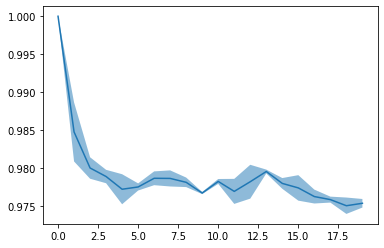

In [167]:
# plot the mean and std
mean, std = get_mean_std(trials)
plt.plot(mean)
plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=.5)